*To Run This Script, Please Download The Dataset From The Following Link:* https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

GitHub Link: https://github.com/Rose-Esmaeili/Bachelor-Final-Projects

# Installing Dependancies

To remove emojies in preprocessing step

In [1]:
pip install emoji --upgrade

To display the application in a user-friendly manner

In [2]:
pip install gradio

In [3]:
pip install transformers torch

In [4]:
# Basic libraries
import numpy as np
import pandas as pd
import csv
import re

# Preprocessing liberaries
import re
import string
from nltk.corpus import stopwords
import nltk
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import emoji

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import torch
from transformers import AutoTokenizer
from transformers import BertTokenizer, BertModel
from tqdm import tqdm  # For progress tracking

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr

In [5]:
nltk.download('stopwords') # A list of common English words (e.g "the", "and") to remove during preprocessing.
nltk.download('punkt_tab') # A pre-trained tokenizer for splitting text into words.
nltk.download('wordnet') # A lexical database for lemmatization.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Loading The Dataset

In [6]:
# Reading and converting the dataset to Panda DataFrame
original_df = pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')

In [7]:
original_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
print(original_df.shape)

(50000, 2)


# Preprocessing

The purpose is to remove noises and prepare the dataset for model training.

In [9]:
# Checking for null cells
null = original_df.isnull().sum()
print(null)

review       0
sentiment    0
dtype: int64


In [10]:
# Checking for duplicate reviews
print("Number of duplicate reviews:", original_df['review'].duplicated().sum())

Number of duplicate reviews: 418


In [11]:
# Dropping Duplicates
original_df = original_df.drop_duplicates()
print(original_df.shape)

(49582, 2)


Since the dataset size is considerably large, another dataset with 2000 rows (with 50% positive sentiment and 50% negative sentiment) is made from the original dataset. The selection of rows are random.

In [12]:
# Separating positive and negative reviews
positive_reviews = original_df[original_df['sentiment'] == 'positive'].sample(n=1000, random_state=42)
negative_reviews = original_df[original_df['sentiment'] == 'negative'].sample(n=1000, random_state=42)

# Combining both into a new dataset
df = pd.concat([positive_reviews, negative_reviews]).sample(frac=1, random_state=42)  # Shuffle the dataset

In [13]:
# Displaying the first few rows
print(df.head())

                                                  review sentiment
45027  This was the first sequel I'd seen (apart from...  negative
17976  This movie is probably for you. It had an over...  positive
49058  ...and you can look at that statement in diffe...  negative
27839  As a Long Island independent film maker myself...  positive
41060  This movie starts out very VERY slow, but when...  negative


In [14]:
# Displaying shape of the dataset
print(df.shape)

(2000, 2)


The 'preprocess' function uses Regex to define some pattern and remove them from the 'review' column. After that, the function lower case and splits the text (one review at a time) into a list of individual words (tokens). Lastly, the function lemmatize the text.

Lemmatization is chosen over stemming because it preserving interpretability.

In [15]:
def preprocess(text):
    # Compile regex patterns
    tag_pattern = re.compile('<.*?>')
    url_pattern = re.compile(r'https?://\s+\www\.\+s+')
    exclude = string.punctuation
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Convert emojis to text
    text = emoji.demojize(text)

    # Remove tags
    text = tag_pattern.sub(r'', text)

    # Remove URLs
    text = url_pattern.sub(r'', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', exclude))

    # Tokenization and lowercase
    tokens = word_tokenize(text.lower())

    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Merge tokens back into a single string
    return " ".join(tokens)


df['review']=df['review'].apply(preprocess)

# Exploratory Data Analysis (EDA)

In [16]:
df.head()

,review,sentiment
45027,first sequel id seen apart return jafar honest...,negative
17976,movie probably overall meditative quality musi...,positive
49058,look statement different way way first mess gr...,negative
27839,long island independent film maker two theatri...,positive
41060,movie start slow action finally get started li...,negative


Through this part I ensure that the Sentiment is categorical which means it's a classification task, guiding my choice of Logistic Regression and SVC later.

'value_counts(normalize=True)' shows the proportion of each value as a percentages, making it easier to assess balance than raw counts alone. This is crucial for a classification task where imbalance could skew metrics.

sentiment
negative    0.5
positive    0.5
Name: proportion, dtype: float64


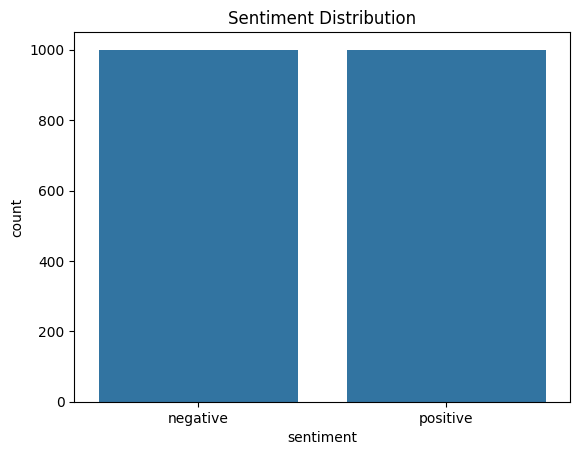

In [17]:
# Counting positive vs negative reviews
print(df['sentiment'].value_counts(normalize=True))
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()

The statistics and the boxplot reveal variability. e.g the maximum number of words in a review is 927 but the mean is 117~, this means many reviews are short but some are outliers. This also helps to decide an appropriate value for TfidfVectorizer setting (max_features=10000) to capture enough vocabulary without overfitting to rare terms in long reviews.

count    2000.000000
mean      116.950000
std        90.886295
min         3.000000
25%        63.000000
50%        87.000000
75%       143.000000
max       927.000000
Name: review_length, dtype: float64


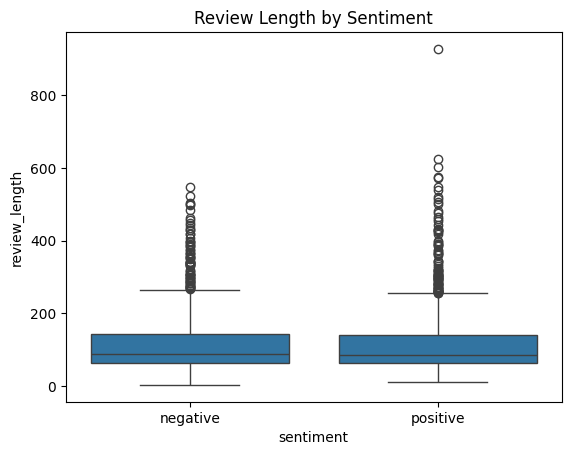

In [18]:
# Add a column for review length (in words)
df['review_length'] = df['review'].apply(lambda x: len(str(x).split()))
print(df['review_length'].describe())  # Summary statistics

# Boxplot by sentiment
sns.boxplot(x='sentiment', y='review_length', data=df)
plt.title('Review Length by Sentiment')
plt.show()

Compares the statistics of negative and positive reviews. They are fairly similar, with positive reviews being slightly longer than negative ones.

In [19]:
# Group by sentiment and describe review lengths
print(df.groupby('sentiment')['review_length'].describe())

            count     mean        std   min   25%   50%     75%    max
sentiment                                                             
negative   1000.0  117.023  85.652594   3.0  63.0  88.0  144.00  547.0
positive   1000.0  116.877  95.877674  12.0  62.0  86.0  139.25  927.0


This section combines all the positive and the negative reviews into single strings. Then it creates two word clouds, each showing the 100 most frequent words, sized by frequency.

There are two purpose for implementing this section:


1.   Seeing words like "great" or "love" in positive clouds and "bad" or "worst" in negative ones confirms sentiment polarity in the vocabulary.
2.   If HTML tags or stopwords dominate, it indicates flwa in preprocessing step.

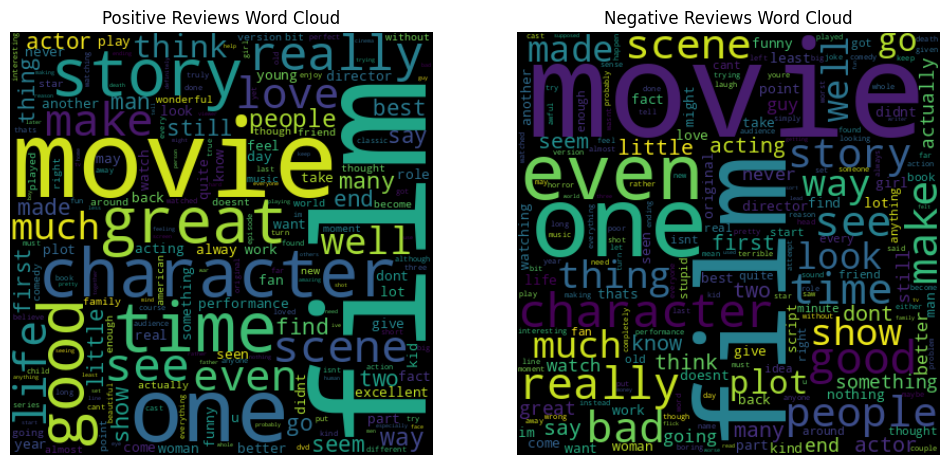

In [20]:
# Separate positive and negative reviews
positive_reviews = ' '.join(df[df['sentiment'] == 'positive']['review'].astype(str))
negative_reviews = ' '.join(df[df['sentiment'] == 'negative']['review'].astype(str))

# Generate word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
wordcloud_pos = WordCloud(width=400, height=400).generate(positive_reviews)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud_neg = WordCloud(width=400, height=400).generate(negative_reviews)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')

plt.show()

# Splitting The Dataset

Creating separate datasets for training (to fit the model) and testing (to evaluate generalization). This split happens before vectorizing to avoid data leakage. This ensurs the test set remains unseen during training, mimicking real-world prediction.

In [21]:
reviews = df['review']  # Text column
labels = df['sentiment']  # Positive/negative labels

# Split the dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    reviews,           # Features (reviews)
    labels,            # Labels (sentiment)
    test_size=0.2,     # 20% for testing
    stratify=labels,   # Ensure the proportion of classes in train & test matches with the dataset
    random_state=42    # controlling the randomness in processes, ensuring the same outcome after each run
)

# Check the shapes
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (1600,)
Test set size: (400,)


In [22]:
# Convert to DataFrame for easier inspection (optional)
train_df = pd.DataFrame({'review': X_train, 'sentiment': y_train})
test_df = pd.DataFrame({'review': X_test, 'sentiment': y_test})

# Check sentiment distribution
print("Training set sentiment distribution:\n", train_df['sentiment'].value_counts(normalize=True))
print("Test set sentiment distribution:\n", test_df['sentiment'].value_counts(normalize=True))

Training set sentiment distribution:
 sentiment
positive    0.5
negative    0.5
Name: proportion, dtype: float64
Test set sentiment distribution:
 sentiment
negative    0.5
positive    0.5
Name: proportion, dtype: float64


# Tokenization

This section vectorize the reviews. Two different approach is taken:

* Bert Tokenizer: Uses pretrained model to tokenize the review column.

This code loads a pre-trained tokenizer for the bert-base-uncased model, which converts raw text into a format that BERT can understand. The "Uncased" in the paranthesis means it treats all text as lowercase and ignores case distinctions (which is not necessary since the preprocess function takes care of this task previously).

Then it loads the pre-trained BERT model itself, specifically the "base" version.

In [23]:
# Loading pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

This function is designed to recieve a list of reviews and convert them into BERT embedings. The batch_size indicate the number of text processed at once and is implemented to prevent the session from crashing.

tqdm() is implimented to track the process of function.

range(0, len(texts), batch_size)) creates a sequence of indices that starts from 0 and increase by batch_size value (0, 32, 64, 96, ..)

Next line slices the texts list to get a batch of texts (32 texts at a time, in this case)

Then it tokenizes the batch of texts. Padding is included to make all the sequences in the batch the same lengh (BERT requires this). Truncation in included to cut text longer than BERT’s maximum input length. return_tensors='pt' is included to returns the tokenized output as PyTorch tensors ensuring compatiblity with BERT model.

The torch.no_grad() disables gradient computation to save memory and speed up inference. And model(**tokens) feeds the tokenized batch into the BERT model. The double stars unpacks the tokens dictionary into keyword arguments.

And lastly, batch_embeddings stores the CLS embeddings for the current batch.

The return is a vertically stacks of all batch embeddings into a single NumPy array

In [24]:
def get_bert_embeddings(texts, batch_size=32):
    all_embeddings = []

    # Convert all text inputs to strings
    texts = [str(text) for text in texts]

    for i in tqdm(range(0, len(texts), batch_size)):  # Process in batches
        batch_texts = texts[i:i+batch_size]  # Get batch
        tokens = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')  # Tokenize batch

        with torch.no_grad():
            outputs = model(**tokens)

        batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # Extract CLS embeddings
        all_embeddings.append(batch_embeddings)

    return np.vstack(all_embeddings)  # Combine all batches

In [25]:
# Convert training and test data to BERT embeddings
X_train_bert = get_bert_embeddings(X_train)
X_test_bert = get_bert_embeddings(X_test)


100%|██████████| 13/13 [12:26<00:00, 57.41s/it]


* TF-IDF: This snippet vectorizes the reviews. Both training and text data are transformed, however only training data is fitted. This is so that the test set is treated as unseen data, , mimicking real-world prediction.

In [26]:
# Initialize and fit on training data only
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)  # Fit and transform training data
X_test_tfidf = vectorizer.transform(X_test)        # Transform test data (no fitting)

# Model Training

LogisticRegression is chosen for this task for several reseaons:


*   It is designed for binary classification
*   no complex hyperparameters tuning
*   It trains quickly on large datasets





In [27]:
# Initialize and train LG using TF-IDF tokenization
lg_model = LogisticRegression(max_iter=1000) #max_iter is the number of iteration it takes the solver to converge
lg_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [28]:
# Initialize and train LG using BERT tokenization
lg_model_bert = LogisticRegression(max_iter=1000)
lg_model_bert.fit(X_train_bert, y_train)

LogisticRegression(max_iter=1000)

The SVC model is also used for text classification and is included in this script to tests a different approach (margin-based) against Logistic Regression (probability-based)

In [29]:
# Initialize and train SVC using TF-IDF tokenization
svc_model = SVC(kernel='linear', max_iter=1000)  # Linear kernel is common for text data
svc_model.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(kernel='linear', max_iter=1000)

In [30]:
# # Initialize and train SVC using BERT tokenization
svc_model_bert = SVC(kernel='linear', max_iter=1000)  # Linear kernel is common for text data
svc_model_bert.fit(X_train_bert, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(kernel='linear', max_iter=1000)

# Evaluation

In [31]:
# Predict on the test set
lg_y_pred = lg_model.predict(X_test_tfidf)
lg_bert_y_pred = lg_model_bert.predict(X_test_bert)
svc_y_pred = svc_model.predict(X_test_tfidf)
svc_bert_y_pred = svc_model_bert.predict(X_test_bert)

This section implements various evaluation metrics to ensure the quality of models' performance. According to the evaluations, Logistic Regression outperfomed SVC model.
*  Accuracy: the fraction of correct predictions on the test set.
*  Precision Score: proportion of predicted "positive" reviews that are truly positive.
*  Recall Score: Proportion of actual "positive" reviews correctly predicted.
*  F1 Score: Harmonic mean of precision and recall, balancing both.
*  Confusion Matrix: Visualizes prediction errors, showing where the model misclassifies
* Classification Report: Summarizes precision, recall, and F1-score for both classes, plus overall accuracy and averages.

In [32]:
# Calculate metrics for LG model using TF-IDF tokenization
lg_accuracy = lg_model.score(X_test_tfidf, y_test)
precision = precision_score(y_test, lg_y_pred, pos_label='positive')  # Specify positive label
recall = recall_score(y_test, lg_y_pred, pos_label='positive')
f1 = f1_score(y_test, lg_y_pred, pos_label='positive')
conf_matrix = confusion_matrix(y_test, lg_y_pred, labels=['negative', 'positive'])

# Print results
print("Evaluation Metrics For LG Model:")
print("Accuracy:", lg_accuracy)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Optional: Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, lg_y_pred, target_names=['negative', 'positive']))

Evaluation Metrics For LG Model:
Accuracy: 0.835
Precision: 0.8045
Recall: 0.8850
F1-Score: 0.8429

Confusion Matrix:
[[157  43]
 [ 23 177]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.79      0.83       200
    positive       0.80      0.89      0.84       200

    accuracy                           0.83       400
   macro avg       0.84      0.83      0.83       400
weighted avg       0.84      0.83      0.83       400



In [33]:
# Calculate metrics for LG model using BERT tokenization
lg_accuracy = lg_model_bert.score(X_test_bert, y_test)
precision = precision_score(y_test, lg_bert_y_pred, pos_label='positive')  # Specify positive label
recall = recall_score(y_test, lg_bert_y_pred, pos_label='positive')
f1 = f1_score(y_test, lg_bert_y_pred, pos_label='positive')
conf_matrix = confusion_matrix(y_test, lg_bert_y_pred, labels=['negative', 'positive'])

# Print results
print("Evaluation Metrics For LG Model:")
print("Accuracy:", lg_accuracy)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


# Optional: Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, lg_bert_y_pred, target_names=['negative', 'positive']))

Evaluation Metrics For LG Model:
Accuracy: 0.8175
Precision: 0.8223
Recall: 0.8100
F1-Score: 0.8161

Confusion Matrix:
[[165  35]
 [ 38 162]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.82      0.82       200
    positive       0.82      0.81      0.82       200

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400



In [34]:
# Calculate metrics for for SVC model using TF-IDF tokenization
svc_accuracy = svc_model.score(X_test_tfidf, y_test)
precision = precision_score(y_test, svc_y_pred, pos_label='positive')  # Specify positive label
recall = recall_score(y_test, svc_y_pred, pos_label='positive')
f1 = f1_score(y_test, svc_y_pred, pos_label='positive')
conf_matrix = confusion_matrix(y_test, svc_y_pred, labels=['negative', 'positive'])

# Print results
print("Evaluation Metrics For SVC Model:")
print("Accuracy:", svc_accuracy)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Optional: Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, svc_y_pred, target_names=['negative', 'positive']))

Evaluation Metrics For SVC Model:
Accuracy: 0.835
Precision: 0.7939
Recall: 0.9050
F1-Score: 0.8458

Confusion Matrix:
[[153  47]
 [ 19 181]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.77      0.82       200
    positive       0.79      0.91      0.85       200

    accuracy                           0.83       400
   macro avg       0.84      0.83      0.83       400
weighted avg       0.84      0.83      0.83       400



In [35]:
# Calculate metrics for SVC model using BERT tokenization
svc_accuracy = svc_model_bert.score(X_test_bert, y_test)
precision = precision_score(y_test, svc_bert_y_pred, pos_label='positive')  # Specify positive label
recall = recall_score(y_test, svc_bert_y_pred, pos_label='positive')
f1 = f1_score(y_test, svc_bert_y_pred, pos_label='positive')
conf_matrix = confusion_matrix(y_test, svc_bert_y_pred, labels=['negative', 'positive'])

# Print results
print("Evaluation Metrics For SVC Model:")
print("Accuracy:", svc_accuracy)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Optional: Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, svc_bert_y_pred, target_names=['negative', 'positive']))

Evaluation Metrics For SVC Model:
Accuracy: 0.7025
Precision: 0.7035
Recall: 0.7000
F1-Score: 0.7018

Confusion Matrix:
[[141  59]
 [ 60 140]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.70      0.70       200
    positive       0.70      0.70      0.70       200

    accuracy                           0.70       400
   macro avg       0.70      0.70      0.70       400
weighted avg       0.70      0.70      0.70       400



In [43]:
# Data for the table
data = {
    "Model & Tokenization": ["LG (TF-IDF)", "LG (BERT)", "SVC (TF-IDF)", "SVC (BERT)"],
    "Accuracy": [0.8350, 0.8175, 0.8350, 0.7025],
    "Precision": [0.8045, 0.8223, 0.7939, 0.7035],
    "Recall": [0.8850, 0.8100, 0.9050, 0.7000],
    "F1-Score": [0.8429, 0.8161, 0.8458, 0.7018]
}

# Create DataFrame
evaluation = pd.DataFrame(data)

# Display the table
evaluation

,Model & Tokenization,Accuracy,Precision,Recall,F1-Score
0,LG (TF-IDF),0.8350,0.8045,0.885,0.8429
1,LG (BERT),0.8175,0.8223,0.810,0.8161
2,SVC (TF-IDF),0.8350,0.7939,0.905,0.8458
3,SVC (BERT),0.7025,0.7035,0.700,0.7018


# Testing

The function is designed to clean a new review using the same preprocessing function as used before to clean the dataset, then vectorize and predict the sentiment of the review.

In [36]:
# Prediction function for Gradio
def predict_sentiment(review):
    """Predict sentiment of a single review."""
    try:
        # Preprocess the review
        cleaned_review = preprocess(review)
        # Vectorize
        review_tfidf = vectorizer.transform([cleaned_review])  # Note: list with one review
        # Predict
        prediction = lg_model.predict(review_tfidf)[0]  # Use global lg_model
        return prediction  # Returns "positive" or "negative"
    except Exception as e:
        return f"Error: {str(e)}"  # Catch and display errors

In [37]:
interface = gr.Interface(
    fn = predict_sentiment,
    inputs = gr.Textbox(lines=2, placeholder="Please Write Your Review Here..."),
    outputs = "text",
    title = "Movie Sentiment Analysis",
    description = "We Will Tell You Whether The Review Is Positive Or Negative!",
    theme = "huggingface"
)

interface.launch()

/usr/local/lib/python3.11/dist-packages/gradio/blocks.py:1115: UserWarning: Cannot load huggingface. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/huggingface (Request ID: Root=1-67e2ee42-02073ebe4d05898c2bbea0df;750a31b0-da5d-404b-bfee-66ba5854f022)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://57a4336decb098139a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Problem Statement

The task is to create a sentiment analysis system that indicates whether a movie review is positive or nagative. The system was trained on a 2000-row dataset from IMDB.

The underlying business problem is to enable the streaming platform to automatically gauge audience sentiment of movies and seriese based on their written reviews. It is critical information in entertainment industry where audience sentiment defines company's fate. Using this invaluable information, the company can adopt effective marketing strategies, predict box office performance, inform content creators and etc. By solving this problem the company can have actionable insghts into customer preferances, reduce manual review analysis cost and improve decision-making process. Relevant data can be collected from streaming platform of the company where viewers leave comments for each movie.


# High-Level System Design

The system comprises several main components:
* Preprocessing Dataset
* EDA
* Splitting Dataset
* Vectorizing
* Training The models
* Evaluation
* Interface

The preprocessing is the first and most important step of the pipeline. First a smaller dataset with 2000 rows is made from the original dataset. Then it cleans the data from noises, duplicates and irrelavant information (such as HTML tags) to enhance the final outcome of the pipeline. This step is connected to EDA and Splitting Dataset steps.

Next step is EDA, whcih gives the pipeline creator an understanding of the dataset. While this part does not have a direct effect on the models' outcome, it is critical for creator to adopt appropriate appraches.

The dataset will be split here into train and test sets. The train set will be used to train the models in the next steps, while the test set will remain 'unseen' to the models to be used for evaluating models' performance. The importance of this step is to prevent data leakage. This step is connected to Vectorizing section.

After splitting the dataset, the data will be vectorize to numerical values so that the computer can understand and process them. Two approaches for this step is taken, TF-IDF (which is by far faster than BERT and simpler to implement, but does not understand the sentiment of text) and BERT (which is slower, more complicated, but understand the sentiment of text). The outputs of this step is used in model training step.

Two models (Logistic Regression and SVC) will be trained on the vectorized data (both approaches), so that they can learn about the sentiment of reviews. Once the models finished training, they predict the sentiment of each review in the test set. The prediction outcome is what will be fed to the evaluation step, and the LG model using TF-IDF vectorization (due to better performance) will be used in prediction step.

On this step of the pipeline, the performance of all the four models will be evaluated using various evaluation metrics to ensure the accuracy and to compare the performance of the two models.

The final step is designed for the users to write their review and recieve the sentiment of their comment.


*The detailed information for each step is explained before the code snippet.*

# Evaluation

These evaluation metrics suggest that the LG and SVC models with TF-IDF tokenization outperform the BERT-based approach. The LG model with TF-IDF achieves an accuracy of 0.835 and an F1-score of 0.8429, with strong recall of 0.8850 and decent precision 0.8045. Considering the unrivaled speed of TF-IDF in tokenization, LG model with TF-IDF is an ideal model for this task.

The SVC model with TF-IDF display strong scores, driven by exceptional recall (0.9050), although its precision (0.7939) suggest more false positives. The confusion matrices, however, suggest minimized false negatives of 19 in this model.

In contrast, BERT tokenization shows weaker results. The LG model's scores with BERT decrease in accuracy and F1-score. The SVC model with BERT shows even poorer scores and high misclassification rates.

Overall, TF-IDF proves more effective for this task, with SVC excelling in recall and LG offering balance, while BERT’s complexity appears misaligned with the dataset or requires further optimization.

# Conclusion

The sentiment analysis application was created for movie reviews, using Logistic Regression and Support Vector Classifier (SVC) with TF-IDF vectorization, addressing the business need to automate audience sentiment evaluation for the streaming platform. LG emerges as the superior model, achieving an accuracy of 88.37%, with balanced precision (0.8743), recall (0.8973), and F1-score (0.8857), significantly outperforming SVC’s 76.31% accuracy and higher error rate (2,349 vs. 1,153 misclassifications). The system’s strengths lie in robust preprocessing process, LG’s reliability, computational efficiency, and practical deployment through Gradio which makes it accessible for non-technical users to gain rapid insights. However, limitations include SVC’s underperformance, TF-IDF’s lack of contextual understanding (e.g., missing sarcasm or negations), and the binary sentiment constraint, which overlooks nuanced opinions.

For the business problem, LG’s high accuracy ensures reliable sentiment insights, while SVC’s weaknesses and slow pace suggests against its use without optimization. Data-driven recommendations include exploring transformers like BERT for future upgrades and expanding to multi-class sentiment.